In [1]:
#importing packages first:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import cv2
import glob
import os
import pickle
from tqdm import tqdm
from das.api.platform import Platform
from intrinsic_camera_opencv import *

In [2]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [2]:
#Choose a dataset:
dataset1 = '/nas/pixset/exportedDataset/20200331_132623_rec_dataset_camera_intrinsic01_exported/'
#And a the platform:
pf1 = Platform(dataset1)

 33%|███▎      | 2/6 [00:00<00:00,  8.37it/s]/home/olivier/workspace/das/das/api/filesource.py:261: UserWarning: Timestamps are not strictly increasing for datasource file /nas/pixset/exportedDataset/20200331_132623_rec_dataset_camera_intrinsic01_exported/flir_bfc_img.zip
  warnings.warn('Timestamps are not strictly increasing for datasource file {}'.format(self.path))
100%|██████████| 6/6 [00:00<00:00, 10.76it/s]


In [3]:
pf1.datasource_names()

['pixell_bfc_ech',
 'pixell_bfc_cfg',
 'pixell_bfc_sta',
 'flir_bfr_img',
 'flir_bfr_chessboards',
 'flir_bfc_img',
 'flir_bfc_chessboards',
 'flir_bfl_img',
 'flir_bfl_chessboards']

In [4]:
#Which sensor/datasource:
camera_key = 'flir_bfc_img'

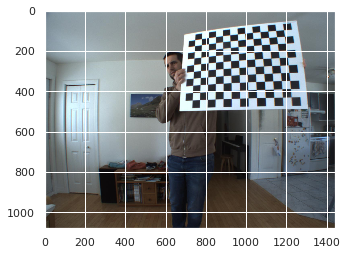

In [5]:
#example:
mu = 31
sample_img = pf1[camera_key][mu].raw
plt.figure()
plt.imshow(sample_img)
plt.show()

In [6]:
sample_img.shape

(1080, 1440, 3)

In [7]:
#Input params:
CHECKERBOARD = (13,10) # num_cols, n_rows
square_lenght = 1
img_shape = (1440, 1080)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.1)
objpoints = []
imgpoints = []

objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp*=square_lenght

In [9]:
#Get corners example:
ret, corners = get_corners(sample_img, 
                            CHECKERBOARD, 
                            criteria,
                            show_img_result=True)
cv2.destroyAllWindows()

In [10]:
# Set a list of frames for calibration:
frames = np.arange(21, 122, 2)

#Calib algo:
ret, mtx, dist, rvecs, tvecs = iterate_over_platform(dataset1, 
                                                        camera_key, 
                                                        CHECKERBOARD, 
                                                        criteria, 
                                                        frames,
                                                        show_img_result=False)

 33%|███▎      | 2/6 [00:00<00:00, 10.54it/s]/home/olivier/workspace/das/das/api/filesource.py:261: UserWarning: Timestamps are not strictly increasing for datasource file /nas/pixset/exportedDataset/20200331_132623_rec_dataset_camera_intrinsic01_exported/flir_bfc_img.zip
  warnings.warn('Timestamps are not strictly increasing for datasource file {}'.format(self.path))
100%|██████████| 51/51 [00:03<00:00, 13.53it/s]


In [11]:
mtx, dist

(array([[821.59082195,   0.        , 734.54377697],
        [  0.        , 821.93889383, 553.15399554],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-2.25776146e-01,  9.92078554e-02, -3.24645851e-04,
         -1.95940364e-04, -2.12160901e-02]]))

In [13]:
#Comparaison:
bfc = '/nas/pixset/exportedDataset/20200519_191244_rec_dataset_calib_ICP_coins01_exported/intrinsics/flir_bfc_calib-results.pkl'
with open(bfc, 'rb') as k:
    calib_bfc = pickle.load(k)

In [16]:
calib_bfc['matrix'], calib_bfc['distortion'] 

(array([[820.24753975,   0.        , 734.30704743],
        [  0.        , 820.78873052, 552.62262377],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-0.22649187,  0.10065042, -0.00026163, -0.00022689, -0.02206318]]))

In [ ]:
#Alternative method (for instance if combining multiple datasets):


In [17]:
#Initialize input parameters
CHECKERBOARD = (13,10) # num_cols, n_rows
square_lenght = 1
img_shape = (1440, 1080)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.1)
objpoints = []
imgpoints = []

objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp*=square_lenght

In [18]:
dataset1 = '/nas/pixset/exportedDataset/20200331_132623_rec_dataset_camera_intrinsic01_exported/'
pf1 = Platform(dataset1)
camera_key = 'flir_bfc_img'
frames = np.arange(21, 122, 2)

 33%|███▎      | 2/6 [00:00<00:00,  9.37it/s]/home/olivier/workspace/das/das/api/filesource.py:261: UserWarning: Timestamps are not strictly increasing for datasource file /nas/pixset/exportedDataset/20200331_132623_rec_dataset_camera_intrinsic01_exported/flir_bfc_img.zip
  warnings.warn('Timestamps are not strictly increasing for datasource file {}'.format(self.path))
100%|██████████| 6/6 [00:00<00:00, 11.77it/s]


In [20]:
for i in tqdm(frames):
    img = np.copy(pf1[camera_key][i].raw)
    ret, corners = get_corners(img, 
                               CHECKERBOARD, 
                               criteria,
                               show_img_result=False)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

100%|██████████| 51/51 [00:03<00:00, 15.94it/s]


In [21]:
objpoints = np.stack(objpoints)
imgpoints = np.stack(imgpoints)

In [22]:
reprojectionError \
    , cameraMatrix \
    , distCoeffs \
    , rvecs \
    , tvecs \
    , stdDeviationsIntrinsics \
    , stdDeviationsExtrinsics \
    , perViewErrors \
    = cv2.calibrateCameraExtended(objpoints, imgpoints, img_shape, None, None, flags=0)

In [23]:
cameraMatrix, distCoeffs

(array([[821.59082195,   0.        , 734.54377697],
        [  0.        , 821.93889383, 553.15399554],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-2.25776146e-01,  9.92078554e-02, -3.24645851e-04,
         -1.95940364e-04, -2.12160901e-02]]))

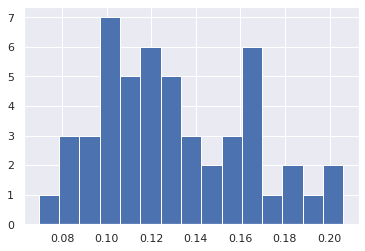

In [26]:
plt.figure()
plt.hist(perViewErrors, bins=15)
plt.show()

In [28]:
#Saving results:
result_bfc = dict(matrix=cameraMatrix,
                  distortion=distCoeffs,
                  rvecs=rvecs,
                  tvecs=tvecs,
                  reprojectionError=reprojectionError,
                  stdDeviationsIntrinsics=stdDeviationsIntrinsics,
                  stdDeviationsExtrinsics=stdDeviationsExtrinsics,
                  perViewErrors=perViewErrors)

#filename:
f="cal_bfc_final.pkl"
pickle.dump(result_bfc, open(f, "wb" ))
